# Similarity Detection in English Language Using RoBERTa

## Task 1: Import Libraries

In [1]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

c:\Users\siddh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task 2: Load and Preprocess the Data

In [2]:
data=[]

for i in range(100):
    original = open('Dataset/Webis-CPC-11/Webis-CPC-11/' + str(i+1) + '-original.txt', 'r')
    original_text = original.read()

    candidate = open('Dataset/Webis-CPC-11/Webis-CPC-11/' + str(i+1) + '-paraphrase.txt', 'r')
    candidate_text = candidate.read()

    with open('Dataset/Webis-CPC-11/Webis-CPC-11/'+ str(i+1) + '-metadata.txt' ) as f:
        for line in f:
            key, value = line.strip().split(':')
            if key=='Paraphrase':
                verdict = value.strip()

    sample = [original_text , candidate_text, verdict]
    data.append([s.replace('\n', ' ') for s in sample])

    
    df=pd.DataFrame(np.array(data), columns=['source', 'target','label'])
    df['label'] = df['label'].map({'Yes':1, 'No':0})

    print(df.head())


                                              source  \
0  M. Comte would not advise so irrational a proc...   

                                              target  label  
0  Even M. Comte would spurn such irrational reas...      1  
                                              source  \
0  M. Comte would not advise so irrational a proc...   
1  Without enumerating all the modern authors who...   

                                              target  label  
0  Even M. Comte would spurn such irrational reas...      1  
1  Just without specifying the current writers wh...      1  
                                              source  \
0  M. Comte would not advise so irrational a proc...   
1  Without enumerating all the modern authors who...   
2  Therefore, a person should search his actions ...   

                                              target  label  
0  Even M. Comte would spurn such irrational reas...      1  
1  Just without specifying the current writers wh...      1

## Task 3: Split the Dataset

In [3]:
train_df = df[:60]
val_df = df[60:80 ]
test_df = df[80:]

## Task 4: Tokenize Datasets

In [4]:
from transformers import AutoTokenizer, AutoModel

# Use a known RoBERTa model
model_name = "roberta-base"  # or "roberta-large"

try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
except Exception as e:
    print(f"Error loading model: {e}")
    # Handle the error (e.g., use a fallback model or exit gracefully)

c:\Users\siddh\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# tokenizer = AutoTokenizer.from_pretrained('models/roberta-similarity')
train_encodings = tokenizer(train_df['source'].tolist(), train_df['target'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['source'].tolist() , val_df['target'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['source'].tolist() , test_df['target'].tolist() , truncation=True, padding=True)

## Task 5: Generate Tensors

In [6]:
class ParaphraseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings= encodings
        self.labels=labels

    def __getitem__(self,idx):
        item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ParaphraseDataset(train_encodings, train_df['label'].tolist())
val_dataset = ParaphraseDataset(val_encodings , val_df['label'].tolist())
test_dataset = ParaphraseDataset(test_encodings , test_df['label'].tolist())
    


## Task 6: Load Pretrained RoBERTa Model and Set Device

In [12]:
model_name = "roberta-similarity"  # or "roberta-large"

try:
    
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
except Exception as e:
    print(f"Error loading model: {e}")

c:\Users\siddh\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Error loading model: roberta-similarity is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`


In [13]:
# model = AutoModelForSequenceClassification.from_pretrained('roberta-similarity', num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## Task 7: Prepare Training Arguments and Create Trainer Object

In [10]:
pip install transformers[torch]

   ---------------------------------------- 0.0/324.4 kB ? eta -:--:--
   ----------------------- ---------------- 194.6/324.4 kB 5.9 MB/s eta 0:00:01
   ---------------------------------------  317.4/324.4 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 324.4/324.4 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/417.5 kB ? eta -:--:--
   ------------- -------------------------- 143.4/417.5 kB 4.3 MB/s eta 0:00:01
   ---------------------- ----------------- 235.5/417.5 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 417.5/417.5 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/286.0 kB ? eta -:--:--
   -------------------- ------------------- 143.4/286.0 kB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 286.0/286.0 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.4.1
    Uninstalling safetensors-0.4.1:
      Successfully unins

  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
pip install accelerate -U

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
training = TrainingArguments(
    output_dir='./results',
    num_train_epochs = 5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size=16,
    warmup_steps = 0, 
    weight_decay = 0.01,
    learning_rate = 5e-5,
    logging_dir = './logs',
    logging_steps=10,
    evaluation_strategy= 'steps',
    save_total_limit = 3,
    load_best_model_at_end=True
)


trainer = Trainer(
    model=model,
    args=training,
    train_dataset= train_dataset,
    eval_dataset =val_dataset,
    data_collator = lambda data: {'input_ids' : torch.stack([item['input_ids'] for item in data]),
    'attention_mask': torch.stack([item['attention_mask'] for item in data]),
    'labels': torch.tensor([item['labels'] for item in data])},
    compute_metrics = lambda pred : {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1))}
    
)

c:\Users\siddh\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


## Task 8: Train the Model

In [15]:
trainer.train()

 50%|█████     | 10/20 [02:07<02:12, 13.23s/it]

{'loss': 0.3431, 'learning_rate': 2.5e-05, 'epoch': 2.5}


                                               
 50%|█████     | 10/20 [02:11<02:12, 13.23s/it]

{'eval_loss': 0.6475726366043091, 'eval_accuracy': 0.75, 'eval_runtime': 4.5901, 'eval_samples_per_second': 4.357, 'eval_steps_per_second': 0.436, 'epoch': 2.5}


100%|██████████| 20/20 [04:24<00:00, 13.54s/it]

{'loss': 0.1617, 'learning_rate': 0.0, 'epoch': 5.0}


                                               
100%|██████████| 20/20 [04:31<00:00, 13.58s/it]

{'eval_loss': 0.7114651203155518, 'eval_accuracy': 0.8, 'eval_runtime': 6.7902, 'eval_samples_per_second': 2.945, 'eval_steps_per_second': 0.295, 'epoch': 5.0}
{'train_runtime': 271.6632, 'train_samples_per_second': 1.104, 'train_steps_per_second': 0.074, 'train_loss': 0.25240904092788696, 'epoch': 5.0}


TrainOutput(global_step=20, training_loss=0.25240904092788696, metrics={'train_runtime': 271.6632, 'train_samples_per_second': 1.104, 'train_steps_per_second': 0.074, 'train_loss': 0.25240904092788696, 'epoch': 5.0})

## Task 9: Test the Model and Calculate Accuracy

In [16]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

true_labels = test_df['label'].tolist()

print('Accuracy:', accuracy_score(true_labels, predicted_labels))


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

Accuracy: 0.85


## Task 10: Compute and Display the Confusion Matrix

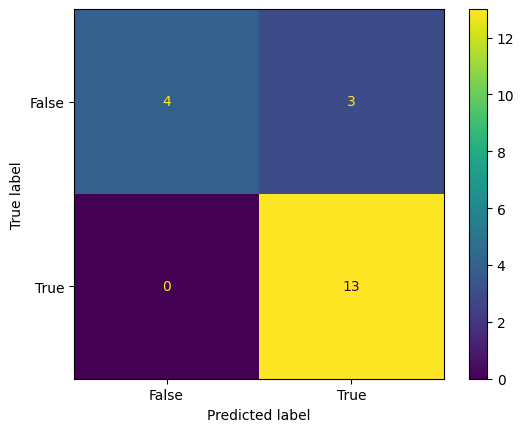

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have your true_labels and predicted_labels

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])

# Plot the confusion matrix
cm_display.plot()